In [237]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
!pip3 install seaborn

    100% |████████████████████████████████| 215kB 14.9MB/s ta 0:00:01
You are using pip version 19.0.3, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [238]:
%load_ext autoreload
%autoreload 2
from utils import *

import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import os
import lightgbm as lgbm
import warnings
from utils import *
import seaborn as sns
from sklearn.metrics import accuracy_score
from parameters import top_tickers, ibkr_tickers

sns.set()

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
load_tickers(data_prefix="data/train", tickers=ibkr_tickers, start_date=datetime.strptime("20170101", "%Y%m%d").date(), end_date=datetime.today().date() + timedelta(days=1), period=3)

 12%|█▏        | 5/41 [00:52<06:20, 10.58s/it]

DSKY


 17%|█▋        | 7/41 [01:04<05:12,  9.20s/it]

FIVE


 61%|██████    | 25/41 [04:11<02:42, 10.18s/it]

RNFT


 76%|███████▌  | 31/41 [05:10<01:55, 11.50s/it]

SFIN


100%|██████████| 41/41 [06:42<00:00, 10.33s/it]


In [174]:
ticker2df = load_dfs('data/train', ibkr_tickers)

DSKY
FIVE
RNFT
SFIN


In [175]:
test_start_day = datetime.today().date() - timedelta(days=32)

train_dates = [test_start_day - timedelta(days=x) for x in range(1, 100)]
val_dates = [test_start_day + timedelta(days=x) for x in range(0, 30)]

In [176]:
X_train, y_train_series = all_samples(ticker2df, train_dates)
X_val, y_val_series = all_samples(ticker2df, val_dates)

In [360]:
def single_target_1(series):
    ser_len = len(series)
    if len(series) > 10:
        can_buy_price = series[1] * 1.005
        can_buy = (series < can_buy_price)[2:5].max()
        if can_buy:
            buy_idx = np.where(series[2:5] < can_buy_price)[0][0] + 1
            
#             can_sell_price = series[0] * 1.025
#             can_sell = (series > can_sell_price)[buy_idx:-3].max()

#             if can_sell:
#                 sell_idx = np.where((series > can_sell_price)[buy_idx:-3])[0][0] + 1
#             else:
#                 sell_idx = -3
#                 sell_idx = len(series[:-5]) + series[-5:].argmin()
                
            sell_idx = len(series[:-5]) + series[-5:].argmin()

            profit = (series[sell_idx] - series[buy_idx]) / series[buy_idx]
                
        else:
            profit = 0
            
    else:
        profit = 0
    
    return profit


def single_target_2(series):
    if len(series) > 10:
        #profit = (series[-5:].min() - series[1]) / series[1]#  > 0.01
        profit = (series[-1] - series[1]) / series[1]  #> 0.01

    else:
        profit = 0
    
    return profit



def single_profit_2(series, return_idxs=False):

    #profit = (series[-5:-4].min() - series[1]) / series[1]#  > 0.01
    #profit = (series[-1] - series[1]) / series[1]  #> 0.01

    UPPER_COEF = 1.003
    BUY_HORIZON = 8
    can_buy = (series[2:BUY_HORIZON] <= series[1]*UPPER_COEF).max()
    if can_buy:
        buy_idx = np.where(series[2:BUY_HORIZON] <= series[1]*UPPER_COEF)[0][0] + 2

        take_profit_price = series[buy_idx] * 1.01
        stop_loss_price = series[buy_idx] * 0.000000995

        take_profit_mask = series[buy_idx:-3] > take_profit_price
        stop_loss_mask = series[buy_idx:-3] < stop_loss_price

        can_sell = (take_profit_mask | stop_loss_mask).max()
        #can_sell = (take_profit_mask ).max()

        if can_sell:
            #sell_idx = np.where(take_profit_mask )[0][0] + 2
            sell_idx = np.where(take_profit_mask | stop_loss_mask)[0][0] + buy_idx
            profit = 0.01

        else:
            sell_idx = len(series)-3

        profit = (series[sell_idx] - series[buy_idx]) / series[buy_idx]
  
    else:
        profit = 0
        buy_idx = len(series)-1
        sell_idx = len(series)-1
        
    if return_idxs:
        return buy_idx, sell_idx
    else:
        return profit



def single_profit(series):
    if len(series) > 10:
        UPPER_COEF = 1.003
        can_buy = (series[2:6] <= series[1]*UPPER_COEF).max()
        if can_buy:
            buy_idx = np.where(series[2:6] <= series[1]*UPPER_COEF)[0][0] + 2
            sell_idx = len(series[:-5]) + np.random.randint(5)#+ series[-5:].argmin()
            sell_idx = -1
            profit = (series[sell_idx] - series[buy_idx]) / series[buy_idx]
        else:
            profit = 0
    else:
        profit = 0
        
    return profit


def calc_target(y_serieses, foo):
    target = []
    for ticker_serieses in y_serieses:
        for series in ticker_serieses:
            val = foo(series)
            target.append(val)
            
    return np.array(target)


def tmp_foo(y_serieses, foo):
    target = []
    k = 0
    for ticker_serieses in y_serieses:
        for series in ticker_serieses:
            val = foo(series)
            target.append(val)
            if k == 1496:
                return series
            k += 1


In [239]:
y_train_profit = calc_target(y_train_series, single_profit_2) 
y_val_profit = calc_target(y_val_series, single_profit_2)


y_train = calc_target(y_train_series, single_target_2) > 0.01
y_val = calc_target(y_val_series, single_target_2) > 0.01


# y_train = y_train_profit #> 0.005
# y_val = y_val_profit #> 0.005

# y_val_profit = calc_target(y_val_series, )


In [131]:
X_train.shape, X_val.shape

((2516, 48), (814, 50))

In [240]:
lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train)

# lgb_2 = lgbm.sklearn.LGBMClassifier()
# lgb_2.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train_2)

# lgb_3 = lgbm.sklearn.LGBMClassifier()
# lgb_3.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train_3)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [241]:
lgb.feature_importances_

array([ 86,  47,  27,  71,  21,  86,  66,  60,  38,  84,  37,  90,  63,
        59,  50,  56,  33,  65,  67,  48,  36,  78,  20,  95,  79,  76,
        58,  79,  28, 106,  72,  85,  48,  70,  43,  81,   8,  16,  62,
        95, 106,  54, 112, 128, 103, 108])

In [243]:
del X_val['profit']
del X_val['profit_abs']

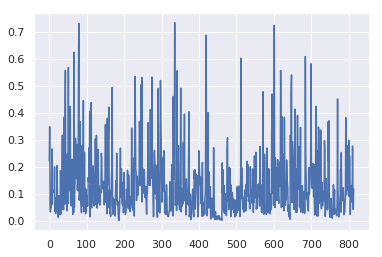

In [244]:
pred_proba = lgb.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
plt.plot(pred_proba)
plt.show()

# pred_proba_2 = lgb_2.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_2)
# plt.show()

# pred_proba_3 = lgb_3.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_3)

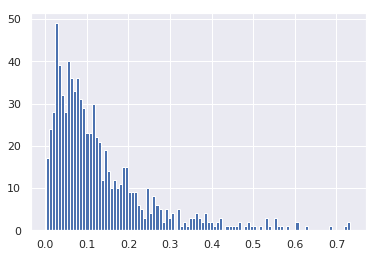

In [245]:
plt.hist(pred_proba, bins=100)
plt.show()

In [258]:
top_idxs = np.where(pred_proba > 0.7)[0]
top_idxs = np.where(pred_proba > 0.4)[0]


In [259]:
len(top_idxs)#, len(top_idxs_2), len(top_idxs_3)

37

In [254]:
y_val.mean(), y_val[top_idxs].mean()

(0.14619164619164618, 0.2112676056338028)

In [255]:
X_val['profit'] = y_val_profit
day_cnt_df = X_val.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_val = pd.merge(X_val, day_cnt_df, on='corn_date', how='left')
X_val['volume'] = 3000000 / X_val['cnt_per_day']
X_val['profit_abs'] = X_val['volume'] * X_val['profit']
del X_val['cnt_per_day']
del X_val['volume']

In [46]:
X_val

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,ticker,corn_date,profit,profit_abs
0,0.019799,0.965615,0.914112,0.971189,0.085888,0.081757,0.007611,0.982944,0.972711,0.980757,...,0.998265,0.918450,NaN,0.001735,91.98000,-0.002174,MOEX,2019-07-03,0.010019,15027.768703
1,0.020890,0.957049,0.904280,0.961551,0.095720,0.088621,0.010998,0.978255,0.963003,0.974080,...,0.998066,0.908148,0.001078,0.009558,92.70000,-0.002157,MOEX,2019-07-04,0.011553,8664.435327
2,0.019781,0.947863,0.899258,0.949311,0.100742,0.100530,0.013363,0.970916,0.949523,0.973383,...,0.996947,0.909434,NaN,0.003053,94.30000,-0.000848,MOEX,2019-07-05,0.010179,NaN
3,0.018124,0.939628,0.903710,0.935807,0.096290,0.088370,0.015876,0.964653,0.939246,0.963735,...,0.991246,0.906628,NaN,0.001876,95.30000,0.001364,MOEX,2019-07-08,0.010537,31612.223393
4,0.020935,0.935074,0.904324,0.927547,0.095676,0.089896,0.017052,0.966538,0.938281,0.962535,...,0.996134,0.907224,0.000985,0.014478,96.42000,-0.000519,MOEX,2019-07-09,-0.014685,-44053.774560
5,0.023820,0.937041,0.903578,0.927091,0.096422,0.078478,0.016043,0.975048,0.946375,0.978034,...,0.995130,0.906500,0.012146,0.002464,95.32000,0.002098,MOEX,2019-07-10,-0.001689,-2532.981530
6,0.024689,0.938832,0.903578,0.927916,0.096422,0.075178,0.012316,0.979478,0.951428,0.979375,...,0.995130,0.906500,0.015446,0.001111,95.00000,0.003474,MOEX,2019-07-11,0.003600,10800.508259
7,0.025066,0.941784,0.907497,0.930185,0.092503,0.060844,0.008441,0.982540,0.968856,0.979581,...,0.995328,0.919644,0.016675,0.001078,94.90000,0.002213,MOEX,2019-07-12,-0.009524,-9523.809524
8,0.025195,0.945076,0.913685,0.933381,0.086315,0.046819,0.010032,0.980421,0.957925,0.977519,...,0.994769,0.919788,0.002166,0.003937,93.97000,-0.003193,MOEX,2019-07-15,0.010095,15141.855276
9,0.025289,0.947527,0.913685,0.934928,0.086315,0.059606,0.008745,0.977108,0.957925,0.976591,...,0.994769,0.919788,0.013228,0.003337,95.18000,0.001261,MOEX,2019-07-16,-0.013064,-19595.448799


In [256]:
X_val.loc[top_idxs].groupby('corn_date')['profit_abs'].sum()

corn_date
2019-07-04      663.142461
2019-07-05     3013.201912
2019-07-08     8571.292619
2019-07-09    -6336.299784
2019-07-10    -6392.542097
2019-07-11    22492.760022
2019-07-12    12434.710003
2019-07-15    -7356.185750
2019-07-16   -30685.326455
2019-07-17    12622.717436
2019-07-18   -11695.566032
2019-07-19     4308.570096
2019-07-22   -12620.665476
2019-07-23    27175.446685
2019-07-24   -23230.825892
2019-07-25    30010.530011
2019-07-26   -39857.981051
2019-07-29    33046.471601
2019-07-30    -8926.239687
2019-07-31   -34671.069342
2019-08-01    28596.123776
2019-08-02    11935.281897
Name: profit_abs, dtype: float64

In [257]:
X_val.loc[top_idxs]['profit_abs'].sum()

13097.546952355075

In [ ]:
91517.8617101984
84287.5011097007

In [ ]:
274337.9430807853
175824.31807198492

In [112]:
X_day = X_val.loc[top_idxs]
X_day = X_day[X_day['corn_date'] == datetime.strptime("20190703", "%Y%m%d").date()]

In [113]:
X_day

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,ticker,corn_date,profit,profit_abs
66,0.069627,0.881841,0.770059,0.891292,0.229941,0.142368,0.015435,0.96123,0.927078,0.960158,...,0.983742,0.777027,0.014954,0.00595,4.725,0.003175,IRAO,2019-07-03,0.013473,40420.114577


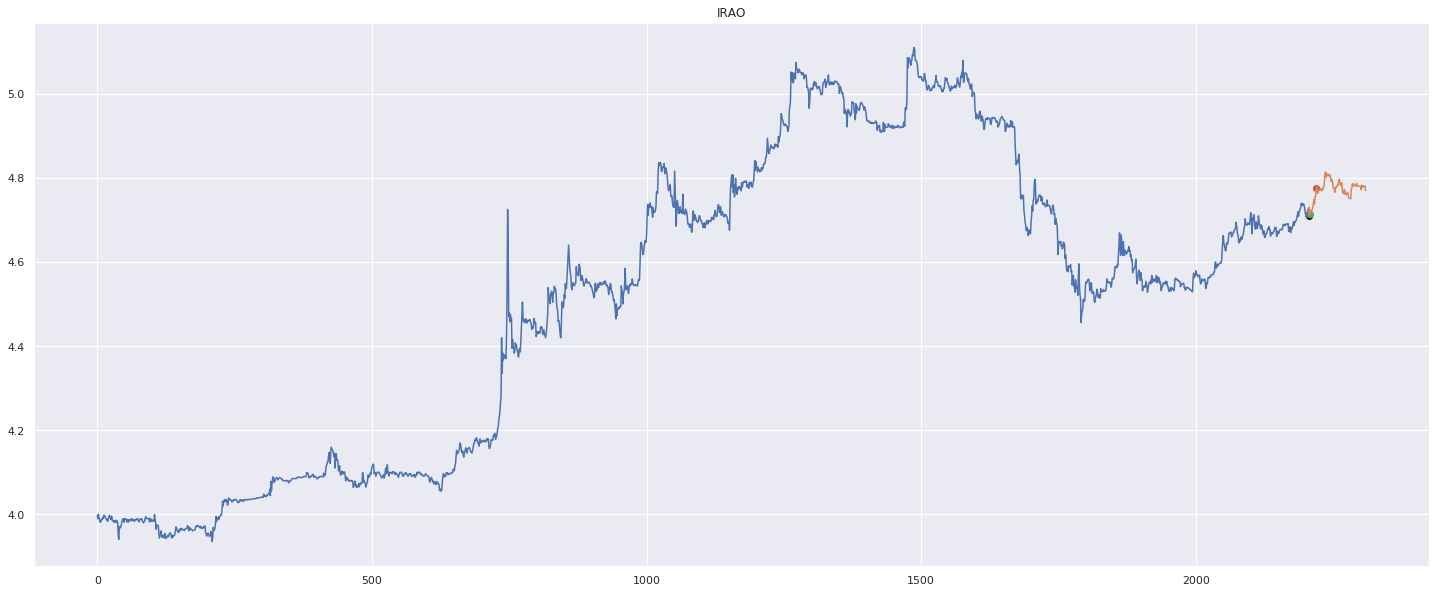

In [114]:
idx = top_idxs[0]
idx = 66
#for idx in top_idxs:
corn_date = X_val.loc[idx]['corn_date']
ticker = X_val.loc[idx]['ticker']

df = ticker2df[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=1))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx = single_profit_2(np.array([0] + list(target_series)), return_idxs=True)
plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx - 1, target_series[buy_idx - 1], color='g')
plt.scatter(len(month_series) + sell_idx - 1, target_series[sell_idx - 1], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')




plt.show()

# Inference

In [683]:

train_dates = [datetime.today().date() - timedelta(days=x) for x in range(1, 100)]

In [48]:
test_start_day

datetime.date(2019, 7, 4)

In [297]:
%%time
ticker2df = load_dfs('data/train', top_tickers[:100])

CPU times: user 1min, sys: 8.17 s, total: 1min 8s
Wall time: 59.6 s


In [322]:
load_tickers(data_prefix="data/current", tickers=ibkr_tickers, start_date=datetime.today().date() - timedelta(days=40), end_date=datetime.today().date(), period=3)

 12%|█▏        | 5/41 [00:06<00:46,  1.30s/it]

DSKY


 17%|█▋        | 7/41 [00:07<00:37,  1.09s/it]

FIVE


 61%|██████    | 25/41 [00:29<00:20,  1.29s/it]

RNFT


 76%|███████▌  | 31/41 [00:37<00:13,  1.36s/it]

SFIN


100%|██████████| 41/41 [00:49<00:00,  1.36s/it]


In [323]:
ticker2df_test = load_dfs('data/current', ibkr_tickers)

DSKY
FIVE
RNFT
SFIN


In [324]:
X_test, y_test_series = all_samples(ticker2df_test, [datetime.today().date()], test_mode=True)

In [325]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,ticker,corn_date
0,0.015307,0.960345,0.921728,0.959163,0.078272,-0.017222,0.004364,0.991724,0.981624,0.992521,...,0.966794,0.959678,0.995256,0.925681,0.002578,0.004537,93.500000,0.001283,MOEX,2019-08-06
1,0.017032,0.965715,0.935614,0.969819,0.064386,0.030891,0.007214,0.983815,0.970377,0.980291,...,0.974636,0.969433,0.995447,0.937565,0.005172,0.000031,81.910000,0.006348,RTKM,2019-08-06
2,0.030059,0.936703,0.896472,0.919896,0.103528,-0.079815,0.005347,0.988788,0.976993,0.988969,...,0.910067,NaN,0.994771,0.910067,0.013595,NaN,155000.000000,-0.006452,TRNFP,2019-08-06
3,0.018573,0.961004,0.884693,0.963085,0.115307,-0.095683,0.026770,0.974790,0.916584,0.989230,...,0.888187,NaN,0.996506,0.888187,0.003494,NaN,4.170000,-0.003597,IRAO,2019-08-06
4,0.014440,0.939139,0.886000,0.938754,0.114000,-0.044713,0.015210,0.967974,0.920806,0.969619,...,0.891757,NaN,0.991939,0.891757,0.001399,NaN,2369.600000,-0.004389,YNDX,2019-08-06
5,0.018548,0.958671,0.893193,0.959383,0.106807,-0.064686,0.015058,0.981104,0.935530,0.987395,...,0.905060,0.896430,0.992448,0.896430,0.007229,0.001402,3581.000000,-0.002234,MGNT,2019-08-06
6,0.015019,0.951791,0.924658,0.950474,0.075342,-0.013435,0.009136,0.981339,0.959275,0.983111,...,0.935312,NaN,0.993151,0.935312,0.000644,NaN,14192.000000,-0.000986,GMKN,2019-08-06
7,0.010811,0.965637,0.941345,0.964235,0.058655,-0.051502,0.006519,0.989798,0.973373,0.988166,...,0.947270,NaN,0.995260,0.947270,0.003064,NaN,0.003305,-0.003030,TGKD,2019-08-06
8,0.028112,0.928401,0.887973,0.920014,0.112027,-0.103788,0.015493,0.980191,0.948171,0.986585,...,0.892500,NaN,0.995474,0.892500,0.002810,NaN,77.750000,-0.002315,ALRS,2019-08-06
9,0.009140,0.977946,0.948492,0.979765,0.051508,-0.036056,0.009972,0.982045,0.957474,0.983101,...,0.950052,NaN,0.984391,0.950052,0.001561,NaN,257.800000,-0.000582,MTSS,2019-08-06


In [ ]:
del X_test['profit']

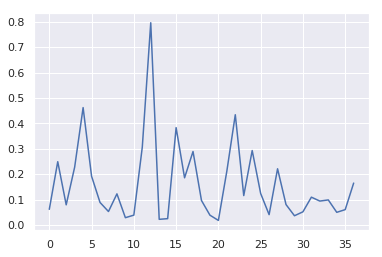

In [326]:
pred_proba = lgb.predict_proba(X_test.drop(['corn_date', 'ticker'], axis=1))[:, 1]
plt.plot(pred_proba)
plt.show()


In [327]:
top_idxs = np.where(pred_proba > 0.4)[0]


In [292]:
ticker2price = {}

for ticker in list(X_test.loc[top_idxs, ['ticker', 'corn_date']]['ticker'].values):
    
    df = ticker2df_test[ticker]
    price = df[df['date']==datetime.today().date()]['<OPEN>'].values[0]
    
    ticker2price[ticker] = price


ticker2price

{'GAZP': 223.62, 'NVTK': 1289.6, 'YNDX': 2380.0}

In [330]:
y_test_profit = calc_target(y_test_series, single_profit_2)

In [334]:
X_test['profit'] = y_test_profit
day_cnt_df = X_test.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_test = pd.merge(X_test, day_cnt_df, on='corn_date', how='left')
X_test['volume'] = 3000000 / X_test['cnt_per_day']
X_test['profit_abs'] = X_test['volume'] * X_test['profit']
del X_test['cnt_per_day']
del X_test['volume']

In [336]:
top_idxs

array([ 4, 12, 22])

In [329]:
X_test.loc[top_idxs, ['ticker', 'corn_date']]

,ticker,corn_date
4,YNDX,2019-08-06
12,GAZP,2019-08-06
22,NVTK,2019-08-06


In [363]:
X_test.loc[top_idxs, ['ticker', 'corn_date', 'profit', 'profit_abs']]

,ticker,corn_date,profit,profit_abs
4,YNDX,2019-08-06,0.01985,19850.281773
12,GAZP,2019-08-06,0.00000,0.000000
22,NVTK,2019-08-06,0.01040,10400.496740


In [1082]:
X_test.loc[top_idxs, ['profit']].sum()

profit   -8149.544299
dtype: float64

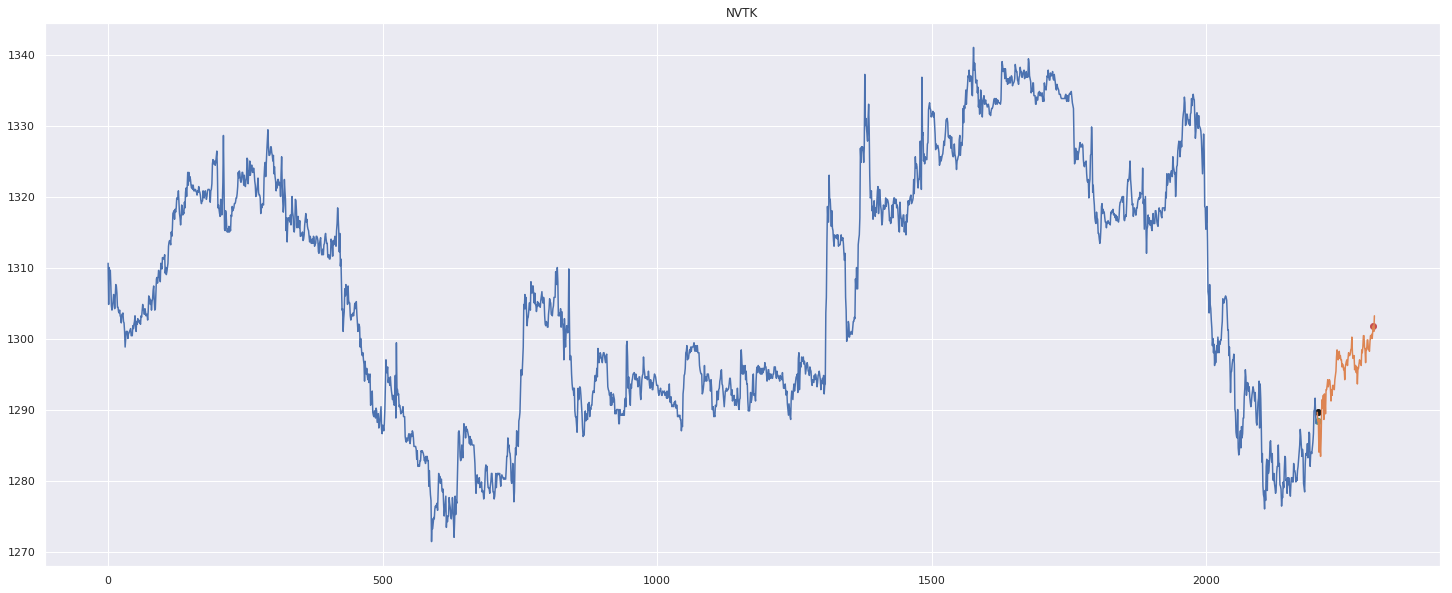

In [362]:
idx = 22
#for idx in top_idxs:
corn_date = X_test.loc[idx]['corn_date']
ticker = X_test.loc[idx]['ticker']

df = ticker2df_test[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=1))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx = single_profit_2(np.array([0] + list(target_series)), return_idxs=True)
plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx - 1, target_series[buy_idx - 1], color='g')
plt.scatter(len(month_series) + sell_idx - 1, target_series[sell_idx - 1], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')




plt.show()

In [353]:
    series = np.array([0] + list(target_series))
    UPPER_COEF = 1.003
    BUY_HORIZON = 118
    can_buy = (series[2:BUY_HORIZON] <= series[1]*UPPER_COEF).max()

In [354]:
can_buy

False

In [352]:
series[2:BUY_HORIZON] <= series[1]*UPPER_COEF

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [356]:
series

array([  0.  , 223.62, 225.25, 225.69, 225.52, 226.03, 225.69, 224.99,
       225.61, 225.81, 225.4 , 225.53, 225.33, 225.2 , 224.4 , 224.64,
       224.66, 225.03, 224.94, 225.13, 224.96, 225.48, 225.53, 225.64,
       225.49, 225.4 , 224.88, 225.23, 225.08, 225.3 , 225.35, 225.28,
       225.39, 225.35, 225.58, 225.59, 225.8 , 225.69, 225.45, 225.42,
       225.29, 225.27, 225.05, 225.26, 225.49, 225.4 , 225.33, 225.15,
       225.46, 225.44, 226.29, 226.2 , 225.98, 226.14, 226.12, 226.48,
       226.47, 227.21, 227.35, 226.8 , 226.63, 227.17, 227.06, 226.84,
       226.89, 226.69, 226.5 , 226.56, 226.31, 226.54, 226.55, 226.68,
       226.34, 226.4 , 226.55, 226.51, 226.4 , 226.53, 226.63, 226.28,
       226.7 , 226.12, 226.58, 226.69, 227.16, 227.23, 227.27, 227.17,
       226.93, 226.71, 226.93, 226.66, 226.99, 226.94, 226.95, 227.05,
       226.85, 226.95, 226.84, 226.61, 226.47, 226.54, 226.9 , 226.98,
       227.04, 226.76])

In [ ]:
data_prefix='data/train'
start_date=datetime.today().date() - timedelta(days=1)
end_date = datetime.today().date() + timedelta(days=1)

ticker='LKOH'
load_single(ticker, 'data/temp', start_date, end_date, 3)


df = pd.read_csv('data/train/{}.csv'.format(ticker))
df['date'] = df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())

upd_df = pd.read_csv('data/temp/{}.csv'.format(ticker))
upd_df['date'] = upd_df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())